# Time Dependent Classification/Regression

I have been interested in time dependent classification/regression for a long time. Most machine learning models are implemented as static models where our assumptions about the relationships between the input variables and the parameters of the models is fixed. This assumption is mostly true, however, there are cases where the model parameters for the same input variable must be allowed to change with time. Furthermore, the change in the model parameters should not be large compared to their value at the previous timesteps. One simple way to approach this problem is to have a different model for each timestep, however, this will not allow us to learn from all the data at hand. The second approach is to have a different parameter for each timestep and a base set of parameters. This second approach although more appropriate will not allow us to enforce our constraint that the model parameters at a given timestep should not change too much from their value at the last timestep. 

How can we encode such relationships in our models? How can we implement these models using existing python libraries? This will be topic of this post. Inspiration for this post comes from [a recent post][1] on a similar topic by Stitchfix.com, you can visit their blog for more details at motivation for using such models in industry. They suggest the approach can be implemented in R using `glmnet` package. Since, I am interested in this kind of problems and since python is my primary language for writing code, I decided to replicate their results using existing python libraries. 
A similar model can be set up in a fully Bayesian way using random walk gaussian priors on the weights at each timestep. This is described in [a wonderful post by Thomas Wiecki][2].

[1]: http://multithreaded.stitchfix.com/blog/2017/09/08/time-dependent-classification/ 
[2]: http://twiecki.github.io/blog/2017/03/14/random-walk-deep-net/

## Problem formulation

$$
\begin{equation}
X = [X_1, X_2, ..., X_t, ..., X_T]\\
Y = [Y_1, Y_2, ..., Y_t, ..., Y_T]\\
Y_t = f_t(X_t)
\end{equation}
$$

Here $X$ in the input data such that at each timestep we get $X_t$ and it's corresponding $Y_t$. A good senario will be a user ($X_t$)'s purchase activity ($Y_t$) on their $t$-th visit or a movie($X_t$)'s earnings($Y_t$) on it's $t$-th week since release.

This data can be modeled as a linear model with time dependent weights as $Y_t = f(X_t, \beta_{t})$, such that $\left\lVert\beta_{t}-\beta_{t-1}\right\rVert$ is small.

Hence, we can reparameterize the equation as suggested in the stitchfix post as $\beta_{t} = \sum_{1}^{t} \delta_{t}$, where $\delta_{t} = \beta_{t} - \beta_{t-1}$ and $\delta_{1} = \beta_{1}$. This reparameterization allows us to use existing classification libraries to implement our model with some modificiation of the input. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import expit as sigmoid

from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.metrics import r2_score, accuracy_score, f1_score

In [2]:
sns.set_context("paper")
sns.set_style("ticks")
np.random.seed(20170911)

## Generating some fake data for time dependent models

One way we can generate the fake data for time-dependent models is by starting with an initial value of weights and then changing the weights in a random walk fashion with some stepsize for each weight. 

In [3]:
N = 5
timesteps=3
def random_walk_values(timesteps, initial_values, stepsize=1):
    '''Generate random walk weights for timesteps starting with initial_vals
    
    Args:
        timesteps: number of timesteps of random walk
        initial_vals: initial values of weights
        stepsize: scalar or vector of same shape as initial_values
    '''
    values = np.zeros((timesteps, *initial_values.shape))
    values[0] = initial_values
    next_values = initial_values
    for i in range(1,timesteps):
        next_values = next_values + np.random.randn(*initial_values.shape)*stepsize
        values[i] = next_values
    return values

In [4]:
random_walk_values(5,np.random.randn(3), stepsize=10)

array([[ -0.78309232,  -0.93589561,   1.03411781],
       [ -0.97358204,  -2.35858223,   1.36900536],
       [-18.09556482, -13.69022841,   4.41890463],
       [-28.13018774, -18.91226046,   1.83061094],
       [-29.00613038, -39.76713231, -14.43907089]])

## Generating the data based on the random walk model

We are going to generate the classification or regression data based on the random walk weights generated above. 

In [5]:
def generate_data(N, timesteps, initial_values, stepsize=1, classification=False):
    weights = random_walk_values(timesteps,initial_values, stepsize)
    X = -5 + np.random.rand(N, initial_values.shape[0] -1)*10
    Y = []
    for i in range(timesteps):
        # y = intercept + X.dot(weights) + error
        y = weights[i, 0] + X.dot(weights[i, 1:])
        if classification:
            y = sigmoid(y)
            y = np.random.binomial(1, y)            
        else:
            y = y + np.random.randn(X.shape[0])
        Y.append(y)
    return [X.copy() for i in range(timesteps)], Y, weights
    
    

In [6]:
N = 100
timesteps=10
initial_values = np.random.randn(2) + 3
stepsize=[2, 1]
X, Y, weights = generate_data(N, timesteps, initial_values=initial_values, stepsize=stepsize)

## Plotting the data

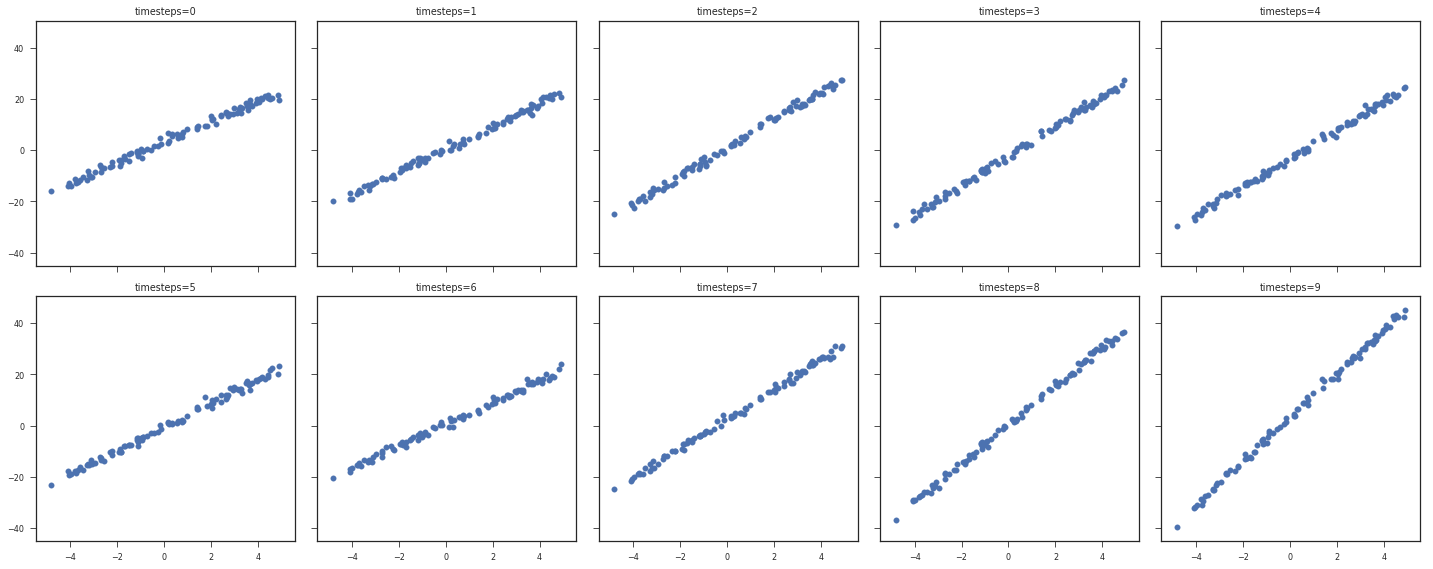

In [7]:
ncols=5
nrows=timesteps//ncols
fig, ax = plt.subplots(
    nrows, ncols, sharex=True, sharey=True, figsize=(4*ncols,4*nrows))
ax = ax.flatten()
for i in range(timesteps):
    ax[i].scatter(X[i][:, 0], Y[i])
    ax[i].set_title(f'timesteps={i}')
    
fig.tight_layout()

As we can see above the relationship between $X$ and $Y$ changes with each timestep. Let us also look at how the weights change over time. 

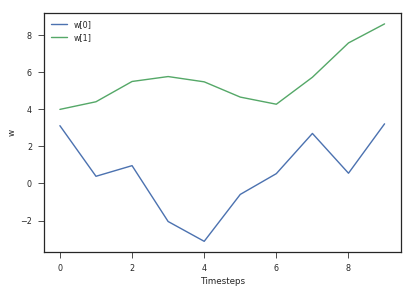

In [8]:
for i in range(weights.shape[1]):
    plt.plot(np.arange(timesteps), weights[:, i], label=f'w[{i}]')
plt.xlabel("Timesteps")
plt.ylabel("w")
plt.legend()

### Fitting a regression model with no time dependence

Let us fit a regression model with no time-dependent on this data. I will use the ElasticNet classifier of sklearn with l1_ratio as zero resulting in a l2 norm on model parameter changes over time. 

In [9]:
model = ElasticNet(l1_ratio=0, alpha=0.1)
model.fit(np.vstack(X), np.hstack(Y))

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

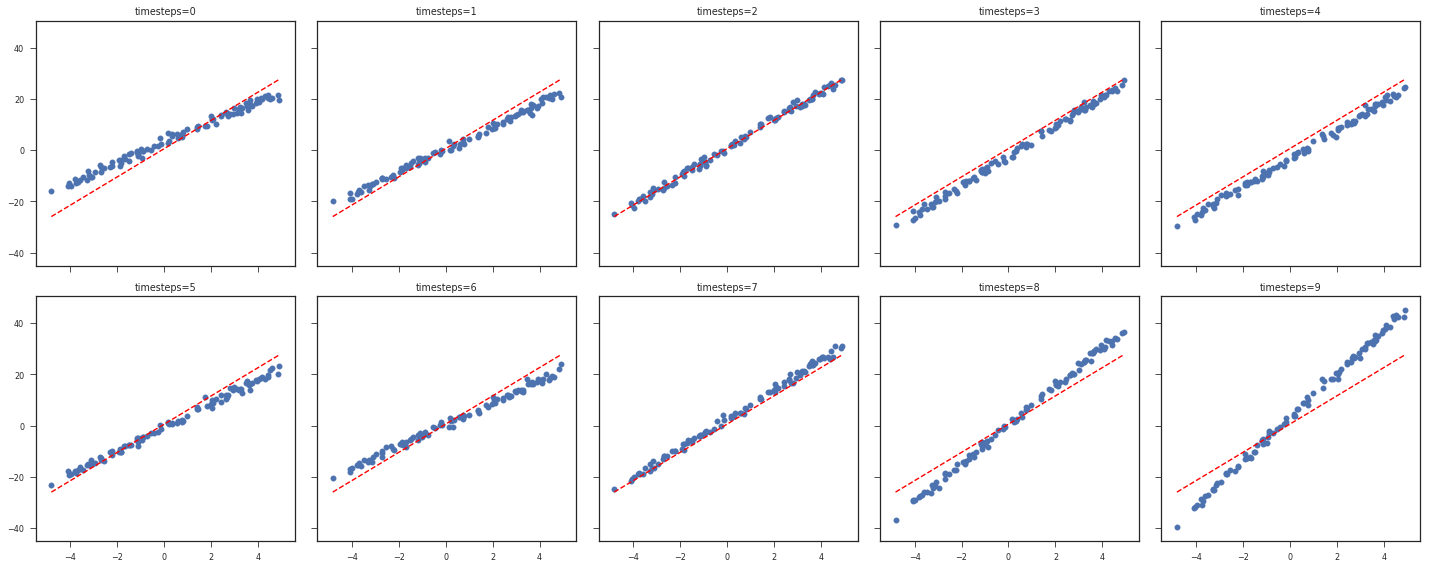

In [10]:
ncols=5
nrows=timesteps//ncols
fig, ax = plt.subplots(
    nrows, ncols, sharex=True, sharey=True, figsize=(4*ncols,4*nrows))
ax = ax.flatten()
X_true = np.arange(X[0].min(), X[0].max(), (X[0].max() - X[0].min())/1000)[:, np.newaxis]
for i in range(timesteps):
    ax[i].scatter(X[i][:, 0], Y[i])
    ax[i].plot(X_true[:, 0], model.predict(X_true), color="r", linestyle="--")
    ax[i].set_title(f'timesteps={i}')
    
fig.tight_layout()

The model above doesn't fit all the timesteps properly, but it does try to model the data as a whole. Furthermore, the R-squared value for each timestep is pretty bad as shown below. 

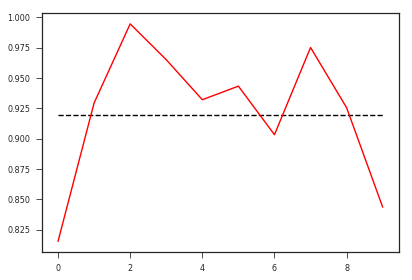

In [11]:
y_true = np.hstack(Y)
y_pred = model.predict(np.vstack(X))
plt.plot(np.ones(timesteps)*r2_score(y_true, y_pred), linestyle="--", color="k")
plt.plot(
    [r2_score(y_true[N*(i):N*(i+1)], y_pred[N*(i):N*(i+1)]) for i in range(timesteps)],
    linestyle="-", color="r"
)

In [12]:
model_params = np.hstack([[model.intercept_], model.coef_])
model_params

array([ 0.59215837,  5.51581555])

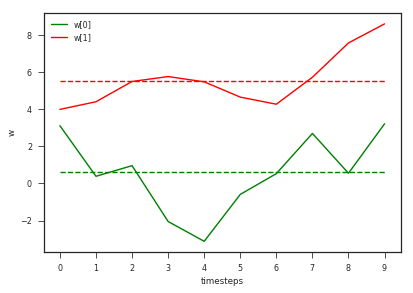

In [13]:
w_colors = ["g", "r"]
for i in range(weights.shape[1]):
    plt.plot(np.arange(timesteps), weights[:, i], label=f'w[{i}]', color=w_colors[i])
    plt.plot(np.arange(timesteps), np.ones(timesteps)*model_params[i], linestyle="--", color=w_colors[i])
plt.xticks(np.arange(timesteps))
plt.xlabel("timesteps")
plt.ylabel("w")
plt.legend()

As you can see above, the model has the same weights for each timestep. 

## Time dependent model

Now let us try to implement our time dependent model as stated above. In order to use the sklearn api we need to change the model input slightly by using time depenent masks and using get_timesensitive function defined below to get the input data in the desired form. This time sensitive input data has each dimension (corresponding to each weight and including the intercept) replicated for each timestep. Furthermore, since skearn adds an intercept by default we can only include $timesteps-1$ intercepts. 

In [14]:
def get_masks(N, timesteps):
    masks = np.zeros((N*timesteps, timesteps))
    for i in range(timesteps):
        masks[N*i:N*(i+1),:(i+1)]=1
    return masks

def get_timesensitive(X, N, timesteps):
    X_cross_w = np.tile(np.vstack(X), (1,timesteps))
    masks = get_masks(N, timesteps)
    print(X_cross_w.shape, masks.shape)
    N_coefs = X[0].shape[1]
    w_mask = np.hstack([np.repeat(masks[:, [i]], N_coefs, axis=1) for i in range(timesteps)])
    X_cross_w = X_cross_w*w_mask
    X_timesensitive = np.hstack([masks[:, 1:], X_cross_w])
    return X_timesensitive


def plot_data_pred(X, Y, model, timesteps, ncols=5):
    r_squared = []
    ncols=5
    nrows=timesteps//ncols
    fig, ax = plt.subplots(
        nrows, ncols, sharex=True, sharey=True, figsize=(4*ncols,4*nrows))
    ax = ax.flatten()
    X_true = np.arange(X[0].min(), X[0].max(), (X[0].max() - X[0].min())/1000)[:, np.newaxis]
    X_true = [X_true.copy() for i in range(timesteps)]
    N_true = X_true[0].shape[0]
    X_true = get_timesensitive(X_true, N_true, timesteps)
    # X_true has first timesteps-1 dimensions as 1 for intercept
    for i in range(timesteps):
        ax[i].scatter(X[i][:, 0], Y[i])
        ax[i].plot(
            X_true[N_true*i:N_true*(i+1), timesteps-1], 
            model.predict(X_true[N_true*i:N_true*(i+1), :]),
            color="r", linestyle="--")
        ax[i].set_title(f'timesteps={i}')

    fig.tight_layout()
    return fig, ax
    
def plot_model_params(weights, model):
    timesteps, n_coefs = weights.shape
    model_coefs = model.coef_.flatten()
    model_delta_params = np.hstack([
        np.array([model.intercept_]).flatten(),
        model_coefs[:timesteps-1],
    ] + [ model_coefs[timesteps+i-1::n_coefs-1] for i in range(n_coefs-1)])
    model_delta_params = model_delta_params.reshape(n_coefs, timesteps)
    model_params = model_delta_params.cumsum(axis=1)
    fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(8,4))
    w_colors = sns.color_palette("Set2", n_coefs)
    for i in range(n_coefs):
        ax[0].plot(np.arange(timesteps), weights[:, i], label=f'w[{i}]', color=w_colors[i])
        ax[1].plot(np.arange(timesteps), model_params[i], linestyle="--", color=w_colors[i])
    #ax.set_xticks(np.arange(timesteps))
    ax[0].set_xlabel("timesteps")
    ax[0].set_ylabel("w")
    ax[1].set_xlabel("timesteps")
    ax[0].legend()
    ax[0].set_title("True")
    ax[1].set_title("Predicted")
    fig.tight_layout()
    return fig, ax


def plot_metrics(model, X, y_true, N, timesteps, metric=r2_score):
    fig, ax = plt.subplots(1,1)
    metrics = []
    y_pred = model.predict(X)
    metric_overall = metric(y_true, y_pred)
    ax.plot(np.ones(timesteps)*metric_overall, linestyle='--', color='k')
    for i in range(timesteps):
        metrics.append(metric(y_true[N*(i):N*(i+1)], y_pred[N*(i):N*(i+1)]))
    ax.plot(metrics, linestyle='-', color='r')
    ax.set_xlabel('timesteps')
    ax.set_ylabel('{}'.format(metric.__name__))
    fig.tight_layout()
    return fig, ax
    

In [15]:
get_timesensitive([np.array([
    [1,2],
    [1,2],
]) for i in range(3)], 2, 3)

(6, 6) (6, 3)


array([[ 0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  1.,  2.,  1.,  2.,  0.,  0.],
       [ 1.,  0.,  1.,  2.,  1.,  2.,  0.,  0.],
       [ 1.,  1.,  1.,  2.,  1.,  2.,  1.,  2.],
       [ 1.,  1.,  1.,  2.,  1.,  2.,  1.,  2.]])

As shown above, the timesensitive data has the dimensions replicated for it's number of timesteps. 

In [16]:
X_timesensitive = get_timesensitive(X, N, timesteps)
X_timesensitive.shape

(1000, 10) (1000, 10)


(1000, 19)

In [17]:
np.hstack(Y).shape

(1000,)

### Fitting the model

Now let us fit the same model as above on the new data. 

(10000, 10) (10000, 10)


(<matplotlib.figure.Figure at 0x7f966f23ddd8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f966fad39b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f966f16be10>], dtype=object))

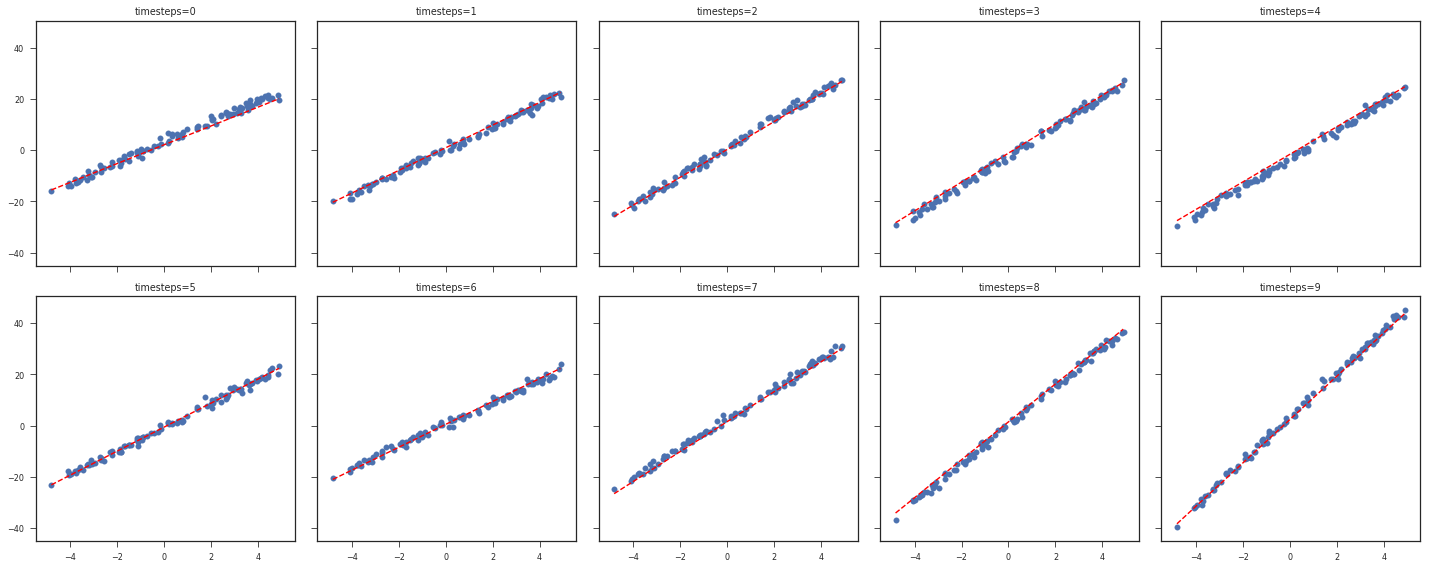

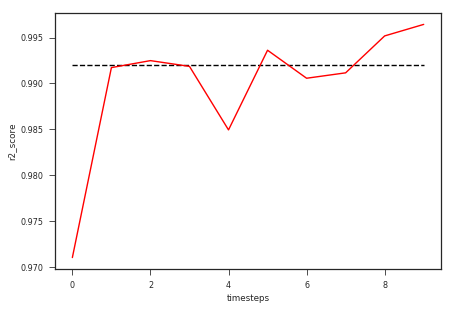

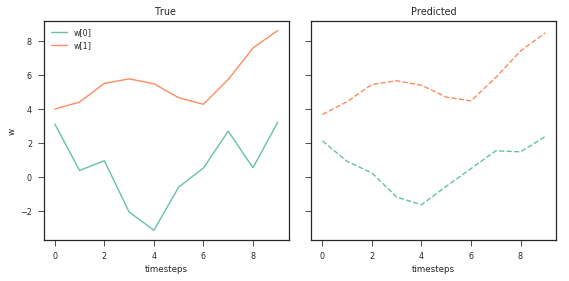

In [18]:
y_true = np.hstack(Y)
model = ElasticNet(l1_ratio=0, alpha=0.1)
model.fit(X_timesensitive, y_true)
plot_data_pred(X, Y, model, timesteps, ncols=5)
plot_metrics(model, X_timesensitive, y_true, N, timesteps, metric=r2_score)
plot_model_params(weights, model)

As we can see our new model fits well to each timestep. The value of alpha can be tuned using cross-validation. Finally, we also see that the weights learned for each timestep are quite similar to the original model weights with smoother transitions. 

## L1 model

Let us also try the L1 norm which enforces sparsity on the weight changes. This will help us have a model with very few parameters. 

(10000, 10) (10000, 10)


(<matplotlib.figure.Figure at 0x7f966c321278>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f966c2b4630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f966f2e0e10>], dtype=object))

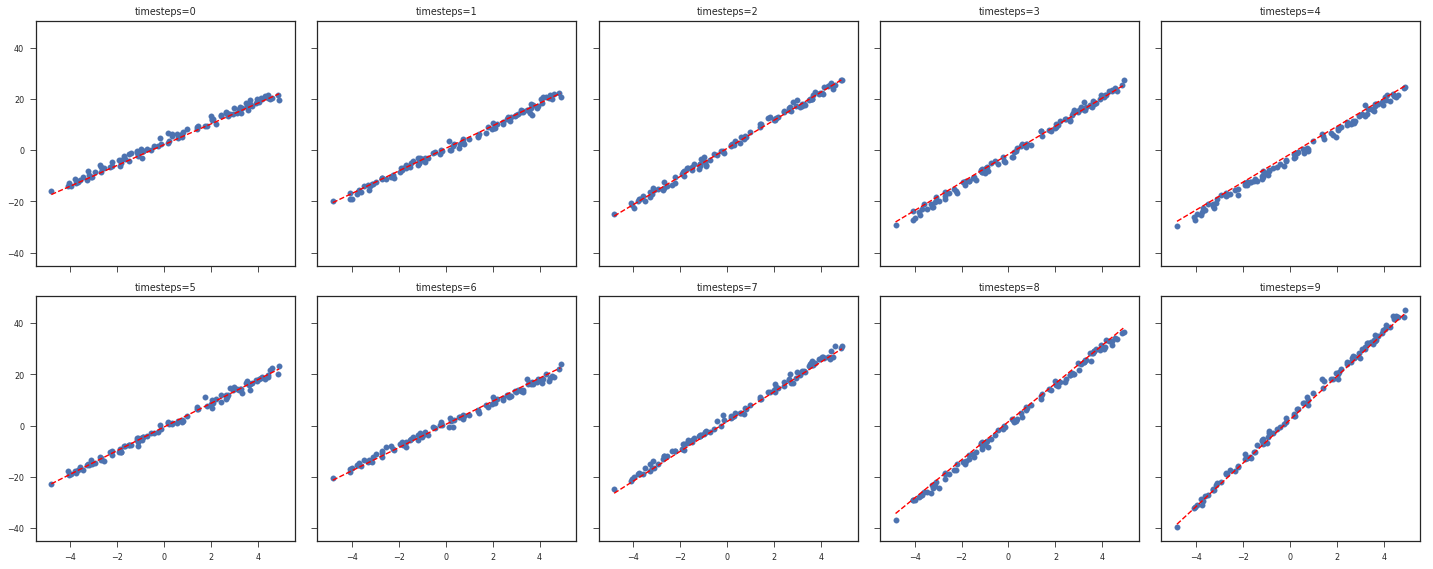

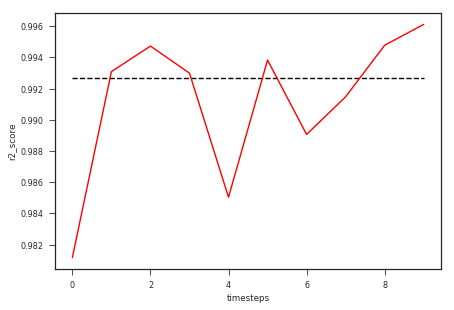

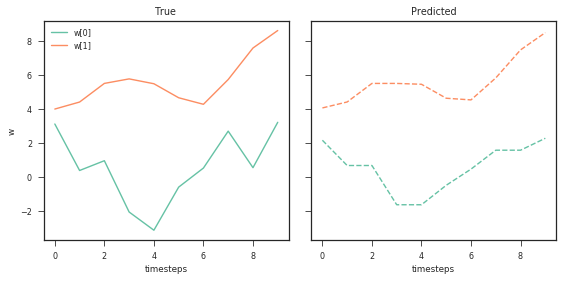

In [19]:
model = ElasticNet(l1_ratio=1, alpha=0.1)
model.fit(X_timesensitive, y_true)
plot_data_pred(X, Y, model, timesteps, ncols=5)
plot_metrics(model, X_timesensitive, y_true, N, timesteps, metric=r2_score)
plot_model_params(weights, model)

## L1 and L2 model

We can extend this further and use an elastic net penalty on the model parameters to improve the performance further. 

(10000, 10) (10000, 10)


(<matplotlib.figure.Figure at 0x7f966c262ef0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f966c1feb00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f966c76ac18>], dtype=object))

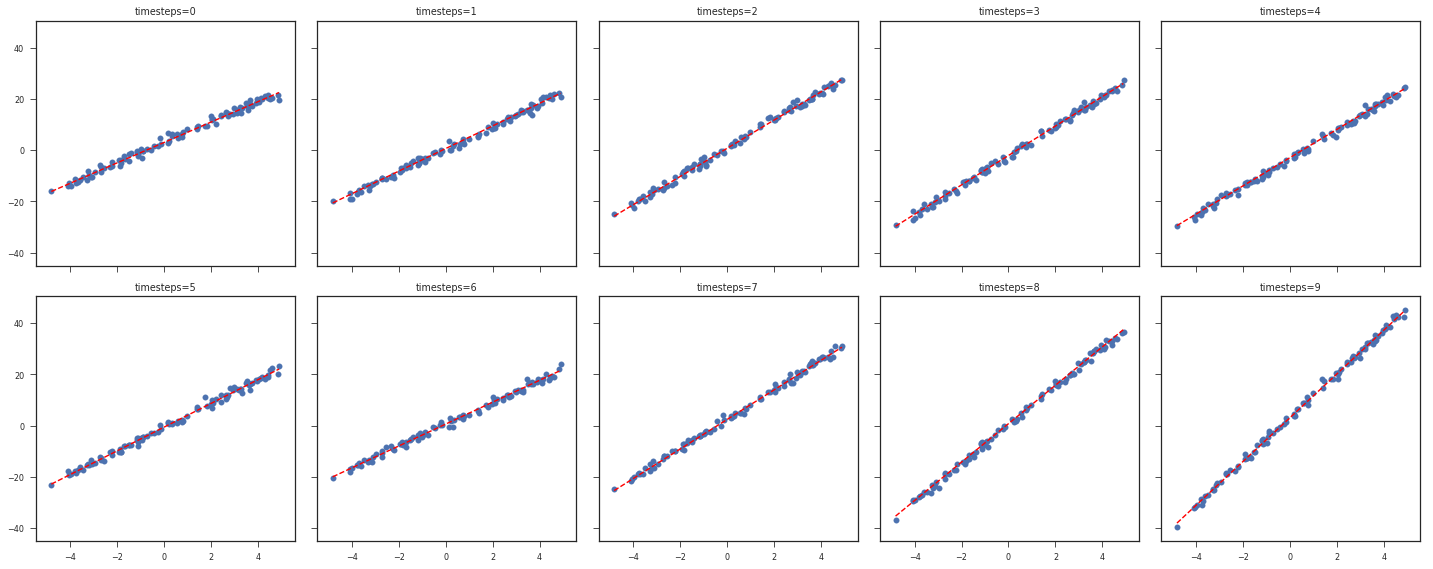

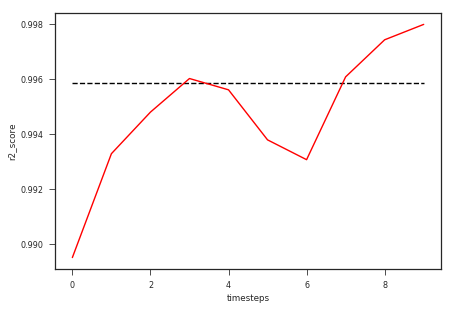

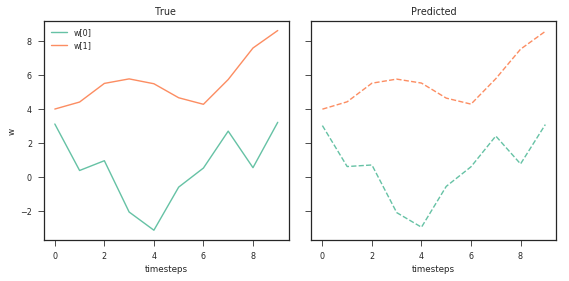

In [20]:
model = ElasticNet(alpha=0.01,l1_ratio=0.5)
model.fit(X_timesensitive, y_true)
plot_data_pred(X, Y, model, timesteps, ncols=5)
plot_metrics(model, X_timesensitive, y_true, N, timesteps, metric=r2_score)
plot_model_params(weights, model)

## Models with more parameters

The above models only had two weights for each timestep (one for x dimension and one intercept), for the sake of visualizing the model versus the fit. Below we extend the model to have more weights and we will only visualize the change in metric and the change in weights. 

In [21]:
N = 100
timesteps=50
N_coefs = 3
initial_values = np.random.randn(N_coefs) + 5
stepsize=np.random.randint(N_coefs, size=N_coefs)
X, Y, weights = generate_data(N, timesteps, initial_values=initial_values, stepsize=stepsize)

In [22]:
X_timesensitive = get_timesensitive(X, N, timesteps)
y_true = np.hstack(Y)
X_timesensitive.shape, y_true.shape

(5000, 100) (5000, 50)


((5000, 149), (5000,))

(<matplotlib.figure.Figure at 0x7f968ac025f8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f966c534240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f966c564748>], dtype=object))

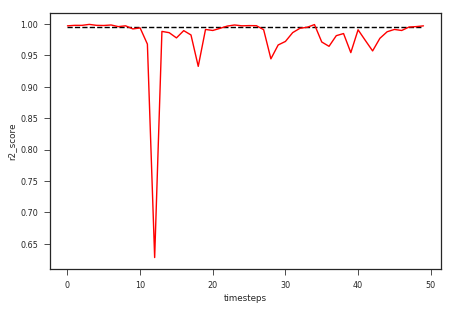

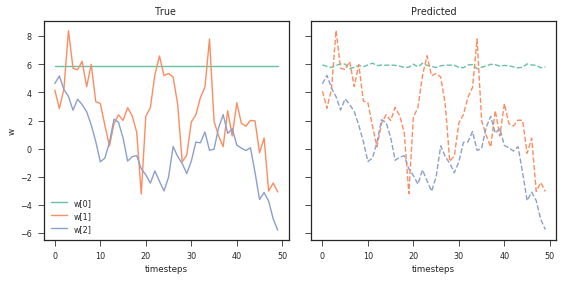

In [23]:
model = ElasticNet(alpha=0.0001,l1_ratio=0.1)
model.fit(X_timesensitive, y_true)
plot_metrics(model, X_timesensitive, y_true, N, timesteps, metric=r2_score)
plot_model_params(weights, model)

In [24]:
stepsize

array([0, 2, 1])

As before the model fits well to the changing weights across timesteps. Let us increase the `l1_ratio` to increase sparsity of the weight changes. 

(<matplotlib.figure.Figure at 0x7f966f067eb8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f966c3009b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f966c732da0>], dtype=object))

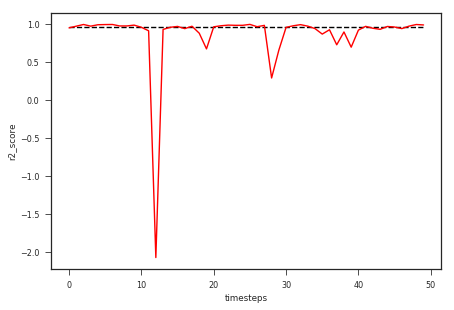

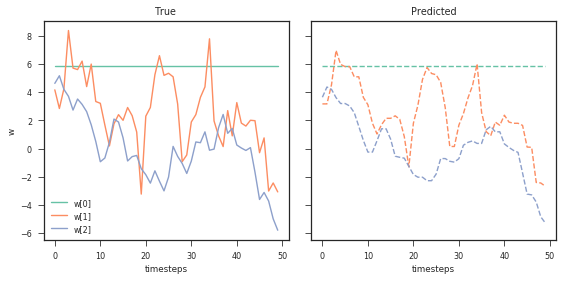

In [25]:
model = ElasticNet(alpha=0.1,l1_ratio=0.5)
model.fit(X_timesensitive, y_true)
plot_metrics(model, X_timesensitive, y_true, N, timesteps, metric=r2_score)
plot_model_params(weights, model)

## Model with lot of time-insensitive parameters

Let us try a model with lot of weights, such that only a few of those change over time. We can implement this by setting the stepsize to 0 for most weights. 

In [26]:
N = 100
timesteps=50
N_coefs = 10
initial_values = np.random.randn(N_coefs) + 5
stepsize=np.random.randint(2,N_coefs, size=N_coefs)
ind = np.arange(N_coefs)
np.random.shuffle(ind)
stepsize[ind[3:]]=0
X, Y, weights = generate_data(N, timesteps, initial_values=initial_values, stepsize=stepsize)

In [27]:
X_timesensitive = get_timesensitive(X, N, timesteps)
y_true = np.hstack(Y)
X_timesensitive.shape, y_true.shape

(5000, 450) (5000, 50)


((5000, 499), (5000,))

In [28]:
stepsize

array([0, 0, 0, 0, 8, 0, 7, 0, 8, 0])

(<matplotlib.figure.Figure at 0x7f966c7709e8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f966c479f98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f966c0d2d68>], dtype=object))

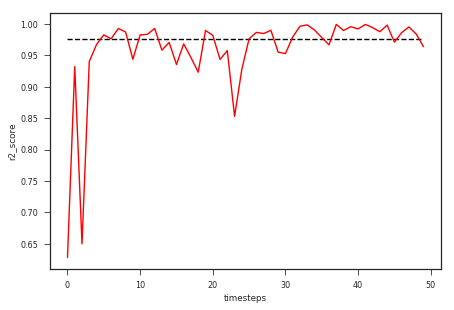

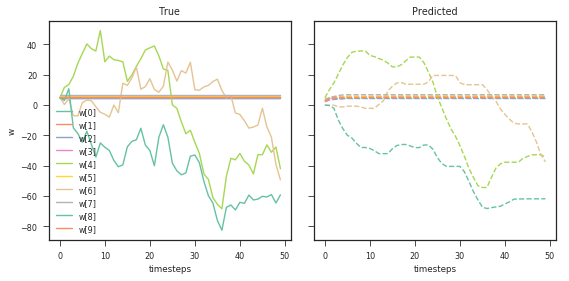

In [29]:
model = ElasticNet(alpha=1,l1_ratio=0.7)
model.fit(X_timesensitive, y_true)
plot_metrics(model, X_timesensitive, y_true, N, timesteps, metric=r2_score)
plot_model_params(weights, model)

As we can observe, the model recovers the parameters correctly, include the ones which don't change over time.

In [30]:
print("Model sparsity is {:.3f}%".format((model.coef_ == 0).mean()*100))

Model sparsity is 71.142%


## Why use such models?

If you notice that while training such models we effectively use $n\_coefs*timesteps$ number of parameters. However, if you notice that $74\%$ of the parameters are zero, meaning while prediction we will only require $26\%$ of the parameters. Furthermore, only $26\%$ of the parameters can sufficiently explain the data using our current model. This is a very useful insight and helps in overall reduction of the complexity of the data generation process. 

## How to implement classification models

Most of us are interested in classification models which share this property of time dependence. One easy way the sklearn api can be used to implement this approach in the classification setting is to use [the code for implementing a custom sklearn model with custom loss](https://github.com/mkliegl/custom-sklearn/blob/master/flexible_linear.py). You can also use LogisticRegression classifier if you don't wish to use the elastic net penalty which is a weighted sum of l1 and l2 penalty. However, using the custom classifier you have control over using the kind of penalty and the kind of penalties you can include e.g. Group Lasso and MCP as suggested in the stichfix blog. Below I will present an example using LogisticRegression classifier. For classification model we will use the `f1_score` as the metric for evaluation.

In [31]:
N = 100
timesteps=50
N_coefs = 10
initial_values = np.random.randn(N_coefs)
stepsize=np.random.randint(3, size=N_coefs)
ind = np.arange(N_coefs)
np.random.shuffle(ind)
stepsize[ind[5:]]=0
X, Y, weights = generate_data(N, timesteps, initial_values=initial_values, stepsize=stepsize, classification=True)

In [32]:
X_timesensitive = get_timesensitive(X, N, timesteps)
y_true = np.hstack(Y)
X_timesensitive.shape, y_true.shape

(5000, 450) (5000, 50)


((5000, 499), (5000,))

In [33]:
stepsize

array([0, 0, 0, 1, 0, 0, 0, 2, 2, 2])

(<matplotlib.figure.Figure at 0x7f968b13b3c8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f966f3e1358>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f966ed57ba8>], dtype=object))

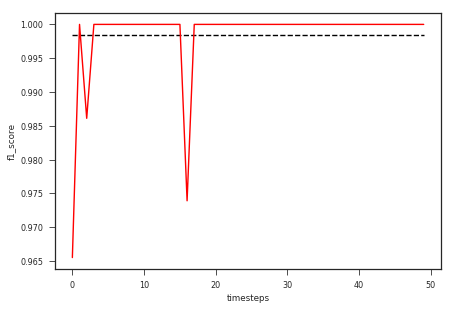

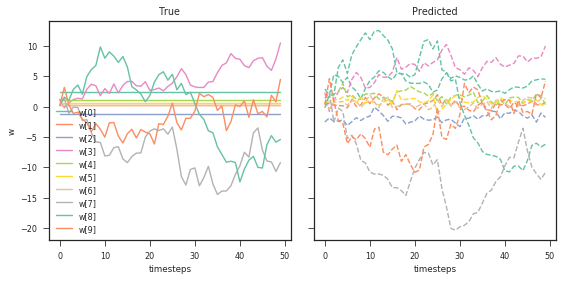

In [34]:
model = LogisticRegression(C=20, penalty='l2')
model.fit(X_timesensitive, y_true)
plot_metrics(model, X_timesensitive, y_true, N, timesteps, metric=f1_score)
plot_model_params(weights, model)

(<matplotlib.figure.Figure at 0x7f966f66ef28>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f966f7c6f98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f966c25b4e0>], dtype=object))

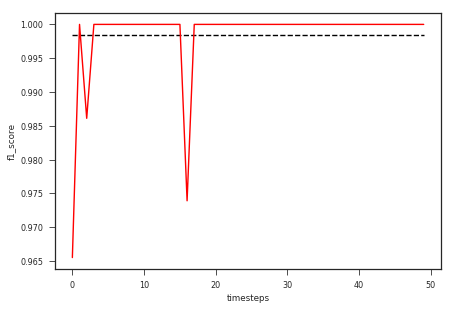

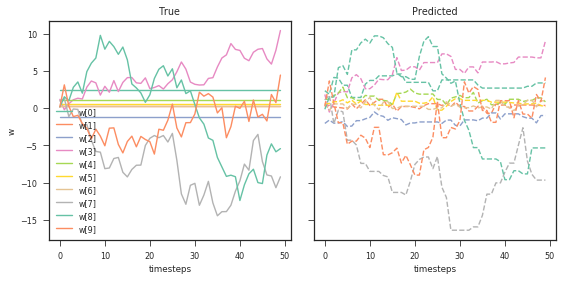

In [35]:
model = LogisticRegression(C=5, penalty='l1')
model.fit(X_timesensitive, y_true)
plot_metrics(model, X_timesensitive, y_true, N, timesteps, metric=f1_score)
plot_model_params(weights, model)

As before the model is able to learn the parameters correctly, although there is a bit more noise for the classification case.